In [1]:
import torch

from torchvision import datasets
from torchvision import transforms
from torch import nn, optim
import timm
from timm.loss import LabelSmoothingCrossEntropy
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os
from tqdm import tqdm
import time
import copy
from torchvision import datasets, transforms, models
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
normal_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

data_dir = r'../data/crop/images/'
dataset = datasets.ImageFolder(data_dir, transform=normal_transforms)

train_size = int(0.7 * len(dataset))
validate_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - validate_size

train_dataset, validate_dataset, test_dataset = random_split(dataset, [train_size, validate_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
validate_loader = torch.utils.data.DataLoader(validate_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, pin_memory=True)

In [4]:
dataloaders ={
    'train': train_loader,
    'validate': validate_loader,
}
dataset_sizes = {
    'train': train_size,
    'validate': validate_size
}

In [15]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

classes = get_classes(data_dir)
print(classes)

['Biological', 'Fibres', 'Films_Coated_Surface', 'MEMS_devices_and_electrodes', 'Nanowires', 'Particles', 'Patterned_surface', 'Porous_Sponge', 'Powder', 'Tips']


In [6]:
model = torchvision.models.resnet18(pretrained=True)

c:\Users\DragonZZ\.conda\envs\ResnetWebApp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DragonZZ\.conda\envs\ResnetWebApp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, len(classes))
)

In [8]:
model = model.to(device)
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0008)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=3):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    val_losses = []
    train_losses = []
    val_acc = []
    train_acc = []
    x = np.arange(1, num_epochs + 1)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch} / {num_epochs - 1}')
        print('-'*10)
        for phase in ['train', 'validate']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0.0
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'phase: {phase}, epoch loss: {epoch_loss}, epoch acc: {epoch_acc}')

            if phase == 'train':
                train_losses.append(float(epoch_loss))
                train_acc.append(float(epoch_acc))
            else:
                val_losses.append(float(epoch_loss))
                val_acc.append(float(epoch_acc))

            if phase == 'validate' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('training time', time_elapsed)
    print('best acc', best_acc)
    
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    
    ax1.plot(x, val_losses,
             color='#444444', linestyle='--', label='validation loss')
    ax1.plot(x, train_losses,
             linestyle='--', label='train loss')
    ax1.legend()
    ax1.set_title('train loss & validation loss')
    ax1.set_ylabel('loss value')
    ax1.set_xlabel('epochs')

    ax2.plot(x, val_acc,
             color='#444444', linestyle='--', label='validation acc')
    ax2.plot(x, train_acc, linestyle='--', label='train acc')
    ax2.legend()
    ax2.set_title('train acc & validation acc')
    ax2.set_ylabel('acc value')
    ax2.set_xlabel('epochs')

    plt.tight_layout()
    plt.show()
    fig1.savefig('./result/loss-resnet18.png', dpi=800)
    fig2.savefig('./result/acc-resnet18.png', dpi=800)

    model.load_state_dict(best_model_wts)
    return model

Epoch 0 / 2
----------


  0%|          | 0/407 [00:00<?, ?it/s]

100%|██████████| 407/407 [00:56<00:00,  7.26it/s]


phase: train, epoch loss: 1.3255621943851164, epoch acc: 0.6513112358686457


100%|██████████| 88/88 [00:09<00:00,  9.67it/s]


phase: validate, epoch loss: 1.2528054667991095, epoch acc: 0.6629576453697057

Epoch 1 / 2
----------


100%|██████████| 407/407 [00:54<00:00,  7.41it/s]


phase: train, epoch loss: 1.0368827739917414, epoch acc: 0.775051911097439


100%|██████████| 88/88 [00:08<00:00, 10.63it/s]


phase: validate, epoch loss: 0.989478875644243, epoch acc: 0.8025843503230439

Epoch 2 / 2
----------


100%|██████████| 407/407 [00:54<00:00,  7.45it/s]


phase: train, epoch loss: 0.945799568460729, epoch acc: 0.8152733984465123


100%|██████████| 88/88 [00:08<00:00, 10.58it/s]

phase: validate, epoch loss: 0.8869029153445943, epoch acc: 0.8388370423546303

training time 191.6750683784485
best acc tensor(0.8388, device='cuda:0', dtype=torch.float64)


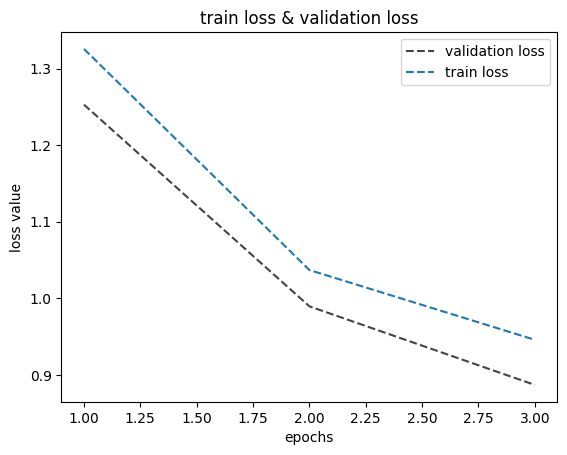

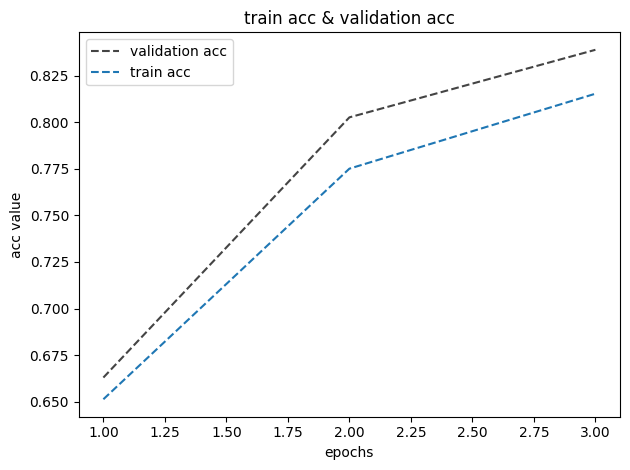

In [14]:
model_trained = train_model(model, criterion, optimizer, exp_lr_scheduler)

model_path = r'../model'
torch.save(model_trained, os.path.join(model_path, 'demo_resnet18'))

In [ ]:
import pickle

def save_agent(agent, filename):
    with open(filename, 'wb') as f:
        pickle.dump(agent, f)

def load_agent(filename):
    with open(filename, 'rb') as f:
        agent = pickle.load(f)
    return agent

save_agent(model, 'demo_save')